# Модульная-1

## 1. *Сформулировать содержательно задачу исследования. Пояснить, как методы регрессионного анализа помогут ее решить (зависимая переменная в модели регрессии должна быть непрерывной величиной). Подобрать данные пространственной выборки для проведения регрессионного анализа. Ограничения: от 5 объясняющих переменных (из них допускается не более 20% бинарных переменных, все прочие - непрерывные), объем выборки от 100 объектов. (1 балл)*

Возьмем данные с сайта kaggle по адресу: https://www.kaggle.com/datasets/shivam2503/diamonds. Это датасет о 53940 бриллиантах по 10 признакми: цена (в US долларах), карат, качество среза, цвет, прозрачность, параметры формы (x, y, z измеренияв мм), глубина (в процентах, рассчитывается из параметров формы), размер площадки (отношение ширины площвдки к диаметру в процентах). Более подробно эти параметры описаны на изображении:

![параметры бриллианта](./parametri_brillianta.png)

Цвет, качество среза и прозрачность тоже переведем в численные значения, фактически, в изначальных данных у нас и так парктически численная оценка, но записанная словами.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./diamonds.csv', index_col=0)

In [3]:
#удалим пропуски значений

df.dropna(inplace=True)

In [4]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [5]:
df.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Теперь переделаем качественные переменные в численные, есть много схем, как это сделать. Ниже одна из них.

![цвет и прозрачность](./color_and_clearity.jpg)

In [6]:
print("cut:", df['cut'].unique())
print("color:", df['color'].unique())
print("clarity:", df['clarity'].unique())

cut: ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color: ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity: ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [7]:
# переделаем качественные параметры
cut_dict = {"Fair":1, "Good":2, "Very Good":3, "Premium":4, "Ideal":5}
df['cut_num'] = df['cut'].replace(cut_dict)

color_dict = {"D":7, "E":6, "F":5, "G":4, "H":3, "I":2, "J":1}
df['color_num'] = df['color'].replace(color_dict)

clarity_dict = {"I1":9, "SI2":8, "SI1":7, "VS2":6, "VS1":5, "VVS2":4, "VVS1":3, "IF":2}
df['clarity_num'] = df['clarity'].replace(clarity_dict)

In [8]:
df.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z,cut_num,color_num,clarity_num
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,5,6,8
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,4,6,7
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,2,6,5
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,4,2,6
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,2,1,8


### Наша задача -- научиться предсказывать *цену* бриллианта по его параметрам.

In [9]:
X = df.drop("price", axis=1)
y = df["price"]

#уберем качественные переменные из выборки
X = X.drop(["cut", "color", "clarity"], axis=1)
X.head(5)

,carat,depth,table,x,y,z,cut_num,color_num,clarity_num
1,0.23,61.5,55.0,3.95,3.98,2.43,5,6,8
2,0.21,59.8,61.0,3.89,3.84,2.31,4,6,7
3,0.23,56.9,65.0,4.05,4.07,2.31,2,6,5
4,0.29,62.4,58.0,4.20,4.23,2.63,4,2,6
5,0.31,63.3,58.0,4.34,4.35,2.75,2,1,8


## 2. *Провести первичный анализ данных. Обосновать выбор переменных, которые будут участвовать в анализе. Описать данные, визуализировать их. Предположить, каким образом независимые переменные должны оказывать влияние на объясняемую переменную из полученных предварительных результатов, общей логики, обзора соответствующей литературы. Провести корреляционный анализ, проверить наличие мультиколлинеарных признаков (в т.ч. с помощью VIFов). (1 балл)*

В первом пункте мы получили следующие численные переменные: вес в каратах, глубина бриллианта и ширина площадки в относительных значениях, x, y и z измерения в абсолютных значениях (в мм), оценки среза, цвета и прозрачности. 

Глубина бриллианта, ширина площадки и x, y и z измерения описывают форму блиррианта, а значит описывают огранку. Есть несколько разных способов огрнаки, но все они стараются приблизиться к некоторой идеальной -- 57-граневой полной традиционной огранке. Чем ближе к этой огранке бриллиант, тем он дороже (ближе по пропорциям, по форме, по кол-ву граней). 

![огранка](./faceting.jpeg)


Источник: https://best-brilliant.ru/info/article/standarty-kachestva/

Заметим, что глубина рассчитывается из x, y и z параметров:

$$ depth = \frac{z}{mean(x, y)} 100\% = 2 \frac{z}{x + y} 100\%$$

Однако я пока не буду выкидывать ее из выборки, потому что пара данных (depth, table) довольно полно описывает форму бриллианта, поэтому нам нужно будет в дальнейшем подумать, какие переменные оставить: depth или явные измерения параметров (x, y, z).

Остальные переменные (вес в каратах, оценки среза, цвета и прозрачности) каждая описывает какое-то одно физическое свойство бриллианта, поэтому их всех тоже оставим. 

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

#посчитаем VIF для каждой объясняющей переменной
y_vif, X_vif = dmatrices('price ~ carat+depth+table+x+y+z+cut_num+color_num+clarity_num', 
                 data=df, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

vif

,VIF,variable
0,6571.603559,Intercept
1,22.000027,carat
2,1.718758,depth
3,1.580986,table
4,56.897612,x
5,20.467345,y
6,23.540975,z
7,1.483721,cut_num
8,1.120267,color_num
9,1.227027,clarity_num


Значение VIF начинается с 1 и не имеет верхнего предела. Общее эмпирическое правило для интерпретации VIF выглядит следующим образом:

- Значение 1 указывает на отсутствие корреляции между данной независимой переменной и любыми другими независимыми переменными в модели.

- Значение от 1 до 5 указывает на умеренную корреляцию между данной объясняющей переменной и другими независимыми переменными в модели, но часто она недостаточно серьезна, чтобы требовать внимания.

- Значение больше 5 указывает на потенциально сильную корреляцию между данной независимой переменной и другими независимыми переменными в модели. В этом случае оценки коэффициентов и p-значения в выходных данных регрессии, вероятно, ненадежны.

То есть, у нас большие проблемы, значения VIF огромные для веса и для измерений параметров. Сначала уберем значение глубины из нашей выборки

In [11]:
#посчитаем VIF без глубины
y_vif, X_vif = dmatrices('price ~ carat+table+x+y+z+cut_num+color_num+clarity_num', 
                 data=df, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

vif

,VIF,variable
0,1176.678110,Intercept
1,21.130461,carat
2,1.341629,table
3,50.301994,x
4,20.272211,y
5,19.071341,z
6,1.313141,cut_num
7,1.118608,color_num
8,1.217311,clarity_num


Если убрать только глубину, то корреляция все равно остается: между измерениями параметрами размера бриллианта и весом. Впомнив курс физики, мы поймем, что это достаточно логично: вес = объем * плотность. Плотность у бриллиантов примерно одинаковая (3,47—3,55 г/см³), поэтому корреляция между объемом и весом (карат) явная. А значит, тройка значения (carat, depth, table) описывает форму бриллианта целиком, и параметры (x, y, z) нам не нужны. 

In [12]:
#посчитаем VIF для объясняющих переменных без (x, y, z)
y_vif, X_vif = dmatrices('price ~ carat+depth+table+cut_num+color_num+clarity_num', 
                 data=df, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

vif

,VIF,variable
0,5239.554308,Intercept
1,1.297731,carat
2,1.320617,depth
3,1.576890,table
4,1.482249,cut_num
5,1.118789,color_num
6,1.200370,clarity_num


Таким образом, параметры (x, y, z) нам не нужны, убираем их.

In [13]:
#уберем переменные (x, y, z)
X = X.drop(["x", "y", "z"], axis=1)
X.head(5)

,carat,depth,table,cut_num,color_num,clarity_num
1,0.23,61.5,55.0,5,6,8
2,0.21,59.8,61.0,4,6,7
3,0.23,56.9,65.0,2,6,5
4,0.29,62.4,58.0,4,2,6
5,0.31,63.3,58.0,2,1,8


### Визуализируем переменные.

Начнем с целевой переменной -- цены бриллианта.

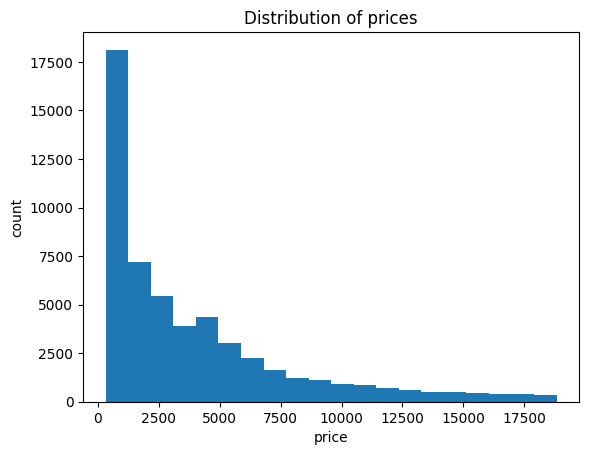

Range: 326 - 18823
Unique values: 11602


In [14]:
plt.hist(y, bins=20)
plt.xlabel('price')
plt.ylabel('count')
plt.title('Distribution of prices')
plt.show()
print(f'Range: {y.min()} - {y.max()}')
print(f'Unique values: {np.unique(y).size}')

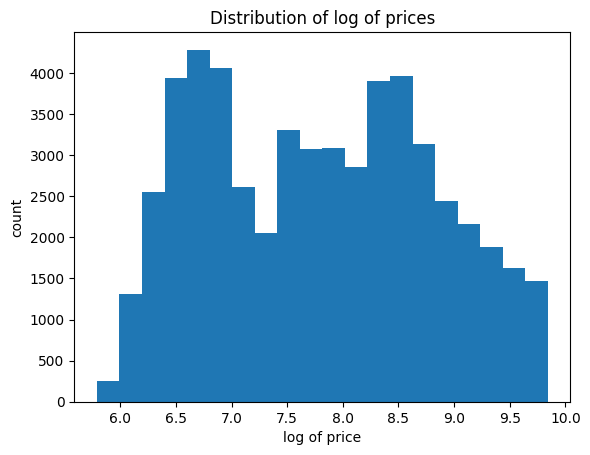

Range of log: 5.7899601708972535 - 9.842887930407198
Unique values: 11602


In [15]:
plt.hist(np.log1p(y), bins=20)
plt.xlabel('log of price')
plt.ylabel('count')
plt.title('Distribution of log of prices')
plt.show()
print(f'Range of log: {np.log1p(y).min()} - {np.log1p(y).max()}')
print(f'Unique values: {np.unique(np.log1p(y)).size}')

Таким образом, распределение логарифма целевой переменной похожа на равномерное ($\sim U[6, 10]$)

Теперь посмотрим на бывшие качесвенные переменные:

<Axes: title={'center': 'Distribution of clarity quality'}, xlabel='clarity quality', ylabel='count'>

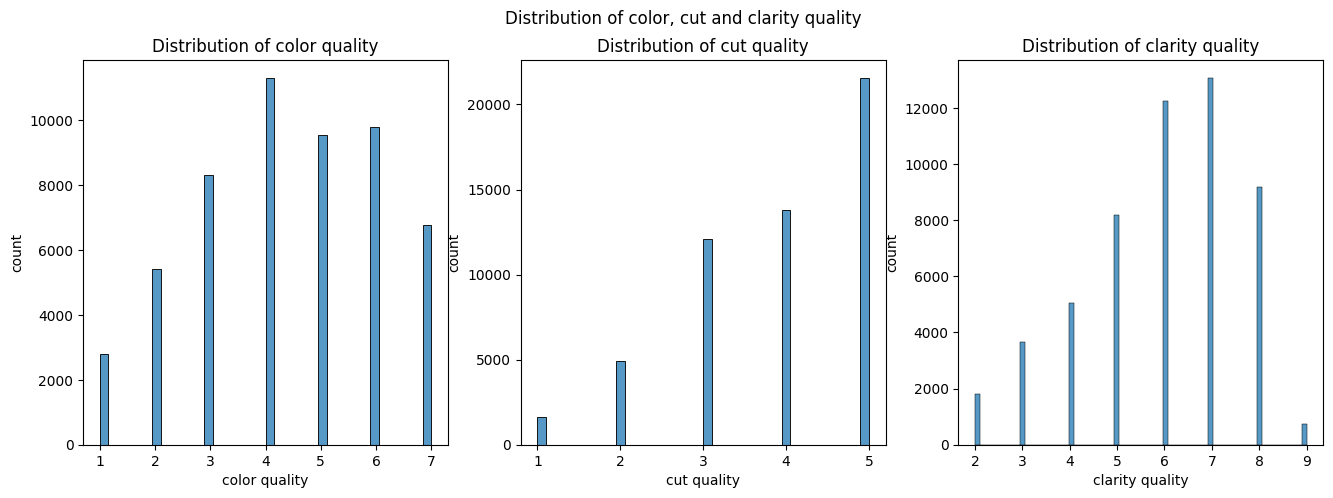

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Distribution of color, cut and clarity quality')

axes[0].set_title('Distribution of color quality')
axes[0].set_xlabel('color quality')
axes[0].set_ylabel('count')
sns.histplot(data=X['color_num'], ax=axes[0], legend=True)

axes[1].set_title('Distribution of cut quality')
axes[1].set_xlabel('cut quality')
axes[1].set_ylabel('count')
sns.histplot(data=X['cut_num'], ax=axes[1], legend=True)

axes[2].set_title('Distribution of clarity quality')
axes[2].set_xlabel('clarity quality')
axes[2].set_ylabel('count')
sns.histplot(data=X['clarity_num'], ax=axes[2], legend=True)

Все хорошо, распределение показывает, что все значения значимые.

Теперь посмотрим на распределения переменных, описывающих форму: carat, table, depth.

<Axes: title={'center': 'Distribution of depth'}, xlabel='depth', ylabel='count'>

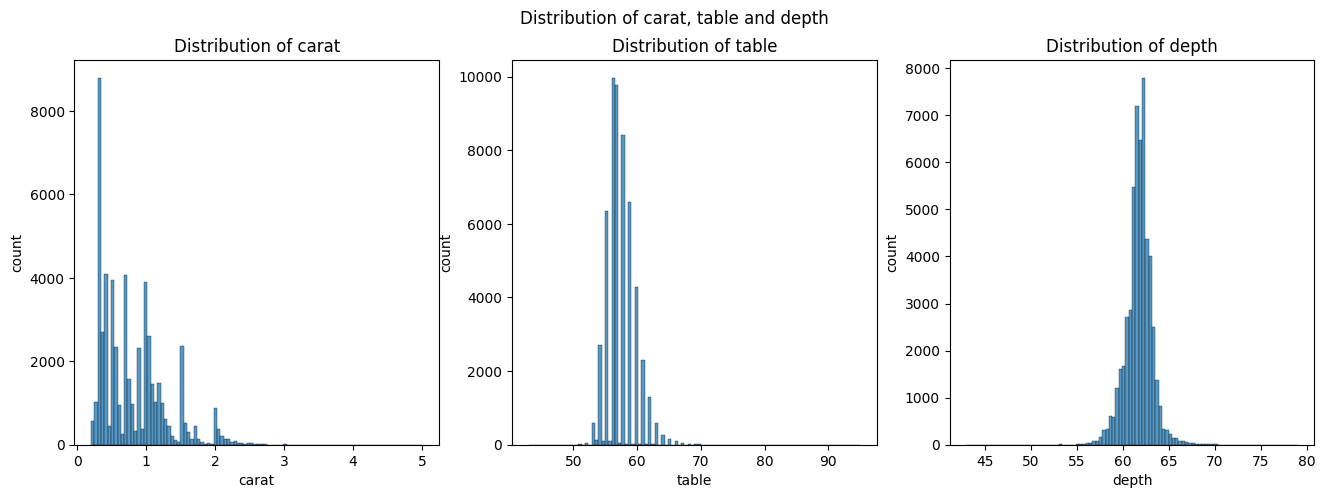

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Distribution of carat, table and depth')

axes[0].set_title('Distribution of carat')
axes[0].set_xlabel('carat')
axes[0].set_ylabel('count')
sns.histplot(data=X['carat'], ax=axes[0], bins=100, legend=True)

axes[1].set_title('Distribution of table')
axes[1].set_xlabel('table')
axes[1].set_ylabel('count')
sns.histplot(data=X['table'], ax=axes[1], bins=100, legend=True)

axes[2].set_title('Distribution of depth')
axes[2].set_xlabel('depth')
axes[2].set_ylabel('count')
sns.histplot(data=X['depth'], ax=axes[2], bins=100, legend=True)

Распределения без аномалий. Распределения переменных "размер площадки" и "глубина" вообще близки к нормальным.

## 3. *Построить уравнение регрессии со значимыми коэффициентами, используя пошаговые алгоритмы регрессионного анализа. Рассмотреть возможность перехода от регрессии исходного признака к регрессии его логарифма (1 балл). Выбрать лучшую из полученных регрессионных моделей̆, основываясь на анализе значений коэффициентов детерминации, остаточных дисперсий и по результатам содержательного анализа моделей̆. (1 балл). На основе графиков выделить переменные, влияющие на гетероскедастичность ошибок. Провести тесты Бройша-Пагана и Уайта для проверки гомоскедастичности ошибок. В случае гетероскедастичности выполнить поправку Уайта.  (1 балл). Провести анализ ошибок модели (1 балл)*

Начнем с регрессионного анализа, только нужно помнить, что надо добавить столбец из свободных элементов.

In [18]:
X.loc[:, ('const')] = 1
X.sample(5)

,carat,depth,table,cut_num,color_num,clarity_num,const
17765,1.05,62.6,58.0,4,5,6,1
11667,1.01,59.0,63.5,2,2,5,1
44007,0.30,61.6,62.0,3,2,7,1
18026,1.50,62.3,59.0,4,3,8,1
8965,1.03,60.7,60.0,4,5,8,1


In [19]:
import statsmodels.api as sm

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 8.503e+04
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:12:46   Log-Likelihood:            -4.6046e+05
No. Observations:               53940   AIC:                         9.209e+05
Df Residuals:                   53933   BIC:                         9.210e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
carat        8793.8028     12.765    688.889      

Значения p-value для всех переменных равны 0, что меньше уровня значимости $\alpha = 0.05$, а значит все переменные значимы. Также, значение метрики $R^2 = 90\%$, то есть мы описываем изменения цены на $90\%$.

Посмотрим, удастся ли нам сильно уменьшить кол-во объясняющих переменных, не снижая особо качество модели. Для этого попробуем отказаться от бывших качественных переменных (качество среза, прозрачности и цвета) в качестве объясняющих переменных, и попробуем построить модель только на основании переменых, описывающих форму.

In [20]:
model = sm.OLS(y, X.drop(["cut_num", "clarity_num", "color_num"], axis=1))
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 1.049e+05
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:12:48   Log-Likelihood:            -4.7194e+05
No. Observations:               53940   AIC:                         9.439e+05
Df Residuals:                   53936   BIC:                         9.439e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
carat       7858.7705     14.151    555.356      0.0

В полученной модели все переменные по-прежнему значимы, но мы потеряли $5\%$ изменения цены по метрике $R^2$ (теперь она равна $85\%$). Однако модель теперь стала в два раза меньше. 

Попробуем теперь посмотреть на самую простую модель -- попробуем предсказать изменение цены только по весу. В целом, больше всего на слуху именно этот параметр бриллианта (часто можно услышать, как невесты после предложения сообщают именно эту информацию о камне в их помолвочном кольце своим подружкам), поэтому можно предположить, что именно этот параметр самый показательный.

In [21]:
model = sm.OLS(y, X[["carat", "const"]])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 3.041e+05
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:12:50   Log-Likelihood:            -4.7273e+05
No. Observations:               53940   AIC:                         9.455e+05
Df Residuals:                   53938   BIC:                         9.455e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
carat       7756.4256     14.067    551.408      0.0

В полученной модели все переменные по-прежнему значимы, однако значение метрики $R^2$ почти не изменилось, несмотря на то, что мы избавились от всех параметров, описывающих форму бриллианта. Значит, от переменных "depth" и "table" мы можем отказаться. 

In [22]:
model = sm.OLS(y, X[["depth", "const"]])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.115
Date:                Thu, 30 Nov 2023   Prob (F-statistic):             0.0134
Time:                        18:15:34   Log-Likelihood:            -5.2377e+05
No. Observations:               53940   AIC:                         1.048e+06
Df Residuals:                   53938   BIC:                         1.048e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
depth        -29.6500     11.990     -2.473      0.0

In [23]:
model = sm.OLS(y, X[["table", "const"]])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     886.1
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          3.76e-193
Time:                        18:15:34   Log-Likelihood:            -5.2334e+05
No. Observations:               53940   AIC:                         1.047e+06
Df Residuals:                   53938   BIC:                         1.047e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
table        226.9837      7.625     29.768      0.0

Построив модели для предсказания цены только по глубине бриллианта и только по размеру площадки мы поймем, что не ошиблись с выбором именно переменной веса бриллианта (каратов) как единственной переменной для описания ценообразования: метрика $R^2$ для остальных двух переменных около 0. 

Теперь перейдем к метрикам качетсва: качеству среза, цвету и прозрачности бриллианта. Цвет и прозрачность можно отнести к описанию камня, а качество среза -- к качеству обработки камня. Поэтому построим две модели: предскажем цену по качеству камня и предскажем цену по качеству обработки.

In [24]:
model = sm.OLS(y, X[["color_num", "clarity_num", "const"]])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1499.
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:38:57   Log-Likelihood:            -5.2232e+05
No. Observations:               53940   AIC:                         1.045e+06
Df Residuals:                   53937   BIC:                         1.045e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
color_num    -413.6695      9.832    -42.074      

In [25]:
model = sm.OLS(y, X[["cut_num", "const"]])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     154.8
Date:                Thu, 30 Nov 2023   Prob (F-statistic):           1.76e-35
Time:                        21:04:15   Log-Likelihood:            -5.2370e+05
No. Observations:               53940   AIC:                         1.047e+06
Df Residuals:                   53938   BIC:                         1.047e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cut_num     -191.1139     15.362    -12.441      0.0

Все p-value около 0, то есть точно меньше уровня значиомти $\alpha = 0.05$, то есть все коэффициента значимые. Смотрим на метрику $R^2$: признаки камня объясняют колебания цены на $5\%$, а для признаков обработки метрика $R^2$ около 0. Поэтому можно сказать, что качество среза можно не учитывать в нашей модели.

Таким образом, оставим в нашей модели вес камня и признаки камня, то есть carat, color_num, clarity_num. То есть, наша финальная модель:

$$price_i = \beta_0 + \beta_1 * carat_i + \beta_2 * \text{color_num}_i + \beta_3 * \text{clarity_num}_i + \varepsilon_i$$

In [26]:
model = sm.OLS(y, X[["carat", "color_num", "clarity_num", "const"]])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 1.661e+05
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:11:31   Log-Likelihood:            -4.6103e+05
No. Observations:               53940   AIC:                         9.221e+05
Df Residuals:                   53936   BIC:                         9.221e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
carat        8755.4676     12.780    685.065      

В полученной модели достигнуто исходное значение метрики $R^2$, то есть модель:

$$price_i = \beta_0 + \beta_1 * carat_i + \beta_2 * \text{color_num}_i + \beta_3 * \text{clarity_num}_i + \varepsilon_i$$

объясняет колебания цены на $90\%$, как и исходная модель:

$$price_i = \beta_0 + \beta_1 * carat_i + \beta_2 * depth_i + \beta_3 * table_i + \beta_4 * \text{cut_num}_i + \beta_5 * \text{color_num}_i + \beta_6 * \text{clarity_num}_i + \varepsilon_i$$

Таким образом, мы сократили кол-во переменных в два раза, сохранив прежний уровень репрезентативности модели.

In [27]:
#уберем ненужные, как оказалось, переменные:
X = X[["const", "carat", "color_num", "clarity_num"]]
X.sample(5)

,const,carat,color_num,clarity_num
2791,1,0.91,1,6
30866,1,0.33,4,6
26759,1,1.57,6,6
18143,1,1.54,1,7
49772,1,0.50,5,4


Посмотим, есть ли смысл переходить от целевой переменной к логарифму целевой переменной.

<Axes: title={'center': 'Distribution of log of price'}, xlabel='log of price', ylabel='count'>

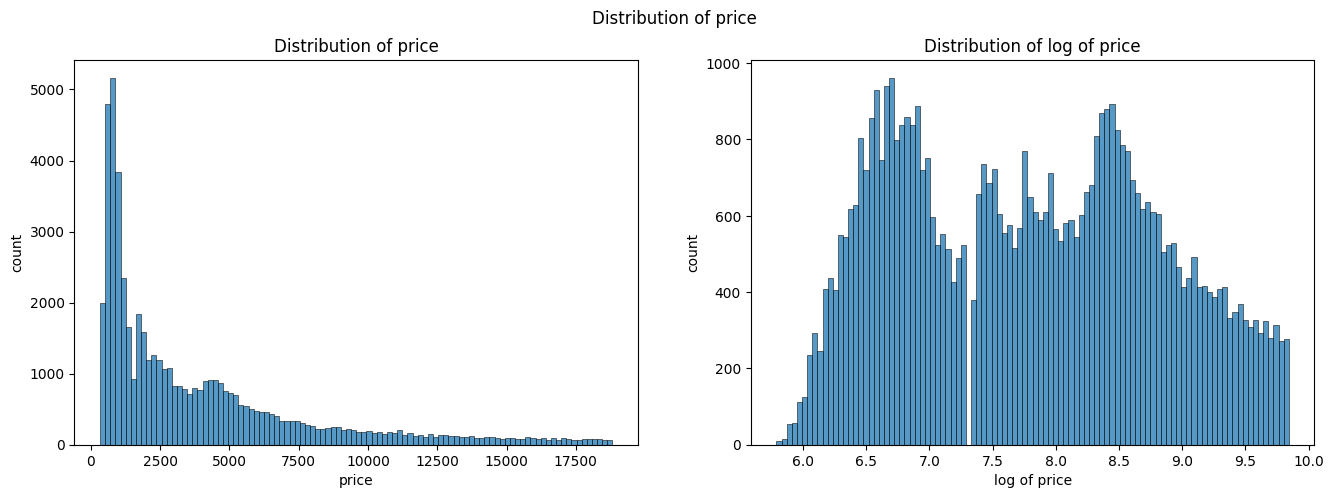

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Distribution of price')

axes[0].set_title('Distribution of price')
axes[0].set_xlabel('price')
axes[0].set_ylabel('count')
sns.histplot(data=y, ax=axes[0], bins=100, legend=True)

axes[1].set_title('Distribution of log of price')
axes[1].set_xlabel('log of price')
axes[1].set_ylabel('count')
sns.histplot(data=np.log1p(y), ax=axes[1], bins=100, legend=True)

Распределение логарифма целевой переменнй выглядит более равномерно, чем распределние целевой переменной, поэтому попробуем перейти к логарифму. Для этого построим следующую модель:

$$ln(price_i + 1) = log1p(price_i) = \beta_0 + \beta_1 * carat_i + \beta_2 * \text{color_num}_i + \beta_3 * \text{clarity_num}_i + \varepsilon_i$$

In [29]:
model = sm.OLS(np.log1p(y), X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 1.315e+05
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:25:43   Log-Likelihood:                -20171.
No. Observations:               53940   AIC:                         4.035e+04
Df Residuals:                   53936   BIC:                         4.039e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.2188      0.007    875.530      

Все переменные по-прежнему значимые, но вот модель стала объяснять колебания цены (логарифма цены) хуже: метрика $R^2$ стала меньше, $88\%$ вместо $90\%$. Поэтому не будем переходить от цены к логарифму цены, останемся с нашей прежней целевой переменной. То есть, остановимся на предыдущей модели:

$$price_i = \beta_0 + \beta_1 * carat_i + \beta_2 * \text{color_num}_i + \beta_3 * \text{clarity_num}_i + \varepsilon_i$$

Теперь будем смотреть на гетероскедастичность нашей модели.

**Нулевая гипотеза**: в данных присутсвует гомоскедастичность.

**Альтернативная гипотеза**: в данных отсутсвтует гомоскедастичность.

In [39]:
import statsmodels.formula.api as smf

fit = smf.ols('price ~ carat+color_num+clarity_num', data=df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 1.661e+05
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:57:22   Log-Likelihood:            -4.6103e+05
No. Observations:               53940   AIC:                         9.221e+05
Df Residuals:                   53936   BIC:                         9.221e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1238.9262     25.178    -49.207      0.000   -1288.275   -1189.578
carat        8755.4676     12.780    685.065      0.000    8730.418    8780.517
color_num     319.8955      3.333     95.969      0.000     313.362     326.429
clarity_num  -541.9427      3.519   -153.985      0.000    -548.841    -535.045
==============================================================================
Omnibus:                    10608.097   Durbin-Watson:                   0.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248977.293
Skew:                           0.339   Prob(JB):                         0.00
Kurtosis:                      13.503   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
lm, lm_pvalue, f_value, f_pvalue = sms.het_breuschpagan(fit.resid, fit.model.exog)
print("lm:", lm)
print("lm pvalue:", lm_pvalue)
print("f-stat:", f_value)
print("f-stat pvalue:", f_pvalue)

lm: 7698.757909986954
lm pvalue: 0.0
f-stat: 2993.28901982312
f-stat pvalue: 0.0


Полученные из теста Бройша-Пагана значения p-value равны 0.000, а значит точно меньше уровня значимости $\alpha=0.05$, то есть мы отвергаем нулевую гипотезу, а именно -- гомоскедастичности нет. То есть, в модели присутствует гетероскедастичность.

In [44]:
#perform White test
lm, lm_pvalue, f_value, f_pvalue = sms.het_white(fit.resid, fit.model.exog)
print("lm:", lm)
print("lm pvalue:", lm_pvalue)
print("f-stat:", f_value)
print("f-stat pvalue:", f_pvalue)

lm: 21164.32005517713
lm pvalue: 0.0
f-stat: 3869.372326260101
f-stat pvalue: 0.0


Полученные из теста Уайта значения p-value равны 0.000, а значит точно меньше уровня значимости $\alpha=0.05$, то есть мы отвергаем нулевую гипотезу, а именно -- гомоскедастичности нет. То есть, в модели присутствует гетероскедастичность.

Таким образом, оба теста указывают на гетероскедастичность, а значит нам нужно провести поправку Уайта:

In [54]:
fit = smf.ols('price ~ carat+color_num+clarity_num', data=df).fit(cov_type = "HC1")
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 3.740e+04
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:32:15   Log-Likelihood:            -4.6103e+05
No. Observations:               53940   AIC:                         9.221e+05
Df Residuals:                   53936   BIC:                         9.221e+05
Df Model:                           3                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1238.9262     27.765    -44.621      0.000   -1293.345   -1184.507
carat        8755.4676     27.258    321.206      0.000    8702.043    8808.893
color_num     319.8955      3.843     83.234      0.000     312.363     327.428
clarity_num  -541.9427      4.466   -121.349      0.000    -550.696    -533.190
==============================================================================
Omnibus:                    10608.097   Durbin-Watson:                   0.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248977.293
Skew:                           0.339   Prob(JB):                         0.00
Kurtosis:                      13.503   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Таким образом, поправки Уайта на результаты модели никак видимо не повлияли.

## 4. Построить модель линейной регрессии с регуляризацией Ридж и применением кросс-валидации, сравнить полученную модель с лучшей моделью из пункта 3. Построить модель линейной регрессии с регуляризацией Лассо применением кросс-валидации, сравнить полученную модель с лучшей моделью из пункта 3 и моделью c регуляризацией Ридж. (1 балла). Сделать обоснованный выбор лучшей модели с регуляризацией, провести анализ ошибок этой модели (1 балл).

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_ridge = RidgeCV()
model_lasso = LassoCV()
model_linreg = LinearRegression()

mse = lambda a, b: mean_squared_error(a, b)
mae = lambda a, b: mean_absolute_error(a, b)
r2 = lambda a, b: r2_score(a, b)

In [47]:
model = model_ridge.fit(X_train, y_train)

y_pred_ridge = model.predict(X_test)

print("MSE for RidgeCV:", mse(y_pred_ridge, y_test))
print("MAE for RidgeCV:", mae(y_pred_ridge, y_test))
print("R2 for RidgeCV:", r2(y_pred_ridge, y_test))

MSE for RidgeCV: 1564304.3784890892
MAE for RidgeCV: 867.3780783404313
R2 for RidgeCV: 0.8935578602148996


In [49]:
model = model_lasso.fit(X_train, y_train)

y_pred_lasso = model.predict(X_test)

print("MSE for LassoCV:", mse(y_pred_lasso, y_test))
print("MAE for LassoCV:", mae(y_pred_lasso, y_test))
print("R2 for LassoCV:", r2(y_pred_lasso, y_test))

MSE for LassoCV: 1564360.285530063
MAE for LassoCV: 866.6914560125808
R2 for LassoCV: 0.8933057317069915


In [55]:
#модель из прошлого пункта
model = sm.OLS(y_train, X_train)
res = model.fit(cov_type = "HC1")

y_pred = res.predict(X_test)

print("MSE for LinReg:", mse(y_pred, y_test))
print("MAE for LinReg:", mae(y_pred, y_test))
print("R2 for LinReg:", r2(y_pred, y_test))

MSE for LinReg: 1564305.1313083388
MAE for LinReg: 867.3845916464469
R2 for LinReg: 0.893560852662049


Методы регуляризации уже лучше сравнивать по значениям метрики MSE (или MAE). Поэтому три модели показывают невысокий результат, но RidgeCV показывает наилучший результат, хотя и не намного.

# 5. Выбрать наиболее удачную регрессионную модель. Аргументировать свой выбор, привести подробную интерпретацию модели. (2 балла)

Таким образом, мы остановились на следующем наборе переменных:

$$price_i = \beta_0 + \beta_1 * carat_i + \beta_2 * \text{color_num}_i + \beta_3 * \text{clarity_num}_i + \varepsilon_i$$

Для расчета использовали модель линейной регрессии с регуляризацией Ридж и применением кросс-валидации.

При выборе набора переменных мы в основном ориентировались на метрику $R^2$, которая показывает полноту объяснения целевой переменной выбранными данными. При выборе же регуляризации для модели линейной регресии мы в основном опирались на метрику MSE. 

Регуляризация особо не влияет на наш результат.

Основное влияние на цену оказывает именно вес бриллианта (то есть, переменная carat), а качество камня лишь помогает нам немного увеличить полноту модели.